<a href="https://colab.research.google.com/github/bhatnira/Acetylcholinesterase-Inhibitor-Discovery/blob/main/classificationModeling_MPNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Message Passing Neural Network Classification Modeling


## Introduction
Message Passing Neural Networks, founded on a sophisticated aggregation methodology and message-passing algorithm, obviates the necessity for elaborate feature engineering by facilitating a holistic analysis of the graph (Gilmer et al., 2017)


## Data loading and Preprocessing



In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.0/954.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 12.1 MB/s eta 0:00:00


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


'2.7.2.dev'

In [ ]:
import deepchem as dc
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Primary Dataset

In [ ]:
import pandas as pd
df=pd.read_excel("/content/drive/MyDrive/Predictive Generative transfer learning/Part_2_standarizationOfMolecule/StandarizedSmiles_cutOFF800daltonMolecularweight.xlsx")

In [ ]:
df.head(5)

,Molecule ChEMBL ID,Smiles,IC50,classLabel,IsValidSMILES,Morgan_FP,Molecule,Fingerprint,PCA1,PCA2,tSNE1,tSNE2,MolecularWeight,Frequency,cleanedMol
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,28.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e880b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.738898,-1.494784,-52.761700,-42.736099,275.352,27,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C
1,CHEMBL207777,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,97.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.014164,-1.325272,-63.027809,-53.765778,325.364,1,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2
2,CHEMBL205967,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,2420.0,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88270>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.235565,-1.559108,-61.968063,-54.078575,263.293,1,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2
3,CHEMBL60119,Cc1ccc2c(N)c3c(nc2c1)CCCC3,100.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88430>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2.705664,0.148113,57.758297,-8.911607,212.296,4,Cc1ccc2c(N)c3c(nc2c1)CCCC3
4,CHEMBL294525,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,290.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e884a0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3.600017,-0.978574,61.242554,5.783804,341.455,3,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2


In [ ]:
# Count the frequency of each label
label_counts = df['classLabel'].value_counts()
# Print the frequency of labels
print(label_counts)

0    2330
1    1747
Name: classLabel, dtype: int64


In [ ]:
df.shape

(4077, 15)

In [ ]:
df.shape

(4077, 15)

In [ ]:
!pip install --pre deepchem

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.2 MB/s eta 0:00:00


In [ ]:
!pip install dgl transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 38.2 MB/s eta 0:00:00


In [ ]:
import deepchem as dc
from deepchem.models.torch_models import GATModel
import matplotlib.pyplot as plt

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


##MolGraphConv Featurization

In [ ]:
import deepchem as dc
import pandas as pd
from rdkit import Chem
from deepchem.feat import ConvMolFeaturizer

featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)

# Featurize the SMILES column
features = featurizer.featurize(df['cleanedMol'].tolist())

# Extract the target values from the DataFrame
targets = df['classLabel'].tolist()

# Create a DeepChem dataset from the features and targets
dataset = dc.data.NumpyDataset(features, targets)

# Split the dataset into training, validation, and test sets
splitter = dc.splits.RandomSplitter()
import deepchem as dc
splitter = dc.splits.RandomSplitter()
train_frac = 0.7
valid_frac = 0.15
test_frac = 0.15

# Use the splitter to split the dataset
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset, frac_train=train_frac, frac_valid=valid_frac, frac_test=test_frac
)


In [ ]:
train_smiles = train_dataset.ids
val_smiles = valid_dataset.ids

In [ ]:
train_smiles

array([261, 820, 2961, ..., 1543, 1191, 2337], dtype=object)

In [ ]:
!pip install dgllife

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
!pip install dgl

In [ ]:
import torch
# Check if CUDA is available
if torch.cuda.is_available():
    # Print CUDA version
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("CUDA is not available on this system.")


CUDA is not available on this system.


In [ ]:
import sklearn
print(sklearn.__version__)

1.2.2


## Message Passing Neural Network Modeling with hyperparameter optimization


In [ ]:
import deepchem as dc
from deepchem.models.torch_models import MPNNModel
# training model
model = MPNNModel(mode='classification', n_tasks=1,
                 batch_size=16, learning_rate=0.001)
loss =  model.fit(train_dataset, nb_epoch=5)


In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV
import deepchem as dc

# Define a function to create and train the GATModel
def create_and_train_gat_model(train_dataset, n_tasks, batch_size, learning_rate, nb_epoch):
    model = GATModel(n_tasks=n_tasks, mode='classification', device='cpu', batch_size=batch_size,
                     learning_rate=learning_rate)
    model.fit(train_dataset, nb_epoch=nb_epoch)
    return model

# hyperparameter search space
param_dist = {
    'n_tasks': [1],
    'batch_size': [8, 16, 32],
    'learning_rate': [0.0001, 0.001, 0.01],
    'nb_epoch': [5, 10, 20]
}

metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

# model_builder function
def model_builder(**model_params):
    n_tasks = model_params['n_tasks']
    batch_size = model_params['batch_size']
    learning_rate = model_params['learning_rate']
    nb_epoch = model_params['nb_epoch']

    return create_and_train_gat_model(train_dataset, n_tasks, batch_size, learning_rate, nb_epoch)

# Create an optimizer and perform hyperparameter search
optimizer = dc.hyper.GridHyperparamOpt(model_builder)
best_model, best_hyperparams, all_results = optimizer.hyperparam_search(param_dist, train_dataset, test_dataset, metric)

# Print the best hyperparameters
print("Best Hyperparameters:", best_hyperparams)


Best Hyperparameters: {'n_tasks': 1, 'batch_size': 8, 'learning_rate': 0.01, 'nb_epoch': 20}
CPU times: user 34min 36s, sys: 9.82 s, total: 34min 46s
Wall time: 35min 53s


## Evaluation of best MPNN model

In [ ]:
import deepchem as dc

# Define the roc_auc_score metric
roc_auc_metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

# Evaluate the model on the training dataset
train_scores = best_model.evaluate(train_dataset, [roc_auc_metric])

# Print available keys in the train_scores dictionary
print("Available keys in train_scores:", train_scores.keys())

# Access the ROC AUC score using the correct key
roc_auc_train_score = train_scores[roc_auc_metric.name]

print('Training set ROC AUC score:', roc_auc_train_score)

# Evaluate the model on the test dataset
test_scores = best_model.evaluate(test_dataset, [roc_auc_metric])

# Print available keys in the test_scores dictionary
print("Available keys in test_scores:", test_scores.keys())

# Access the ROC AUC score using the correct key
roc_auc_test_score = test_scores[roc_auc_metric.name]

print('Test set ROC AUC score:', roc_auc_test_score)


Available keys in train_scores: dict_keys(['roc_auc_score'])
Training set ROC AUC score: 0.9108372359322929
Available keys in test_scores: dict_keys(['roc_auc_score'])
Test set ROC AUC score: 0.891198917872696


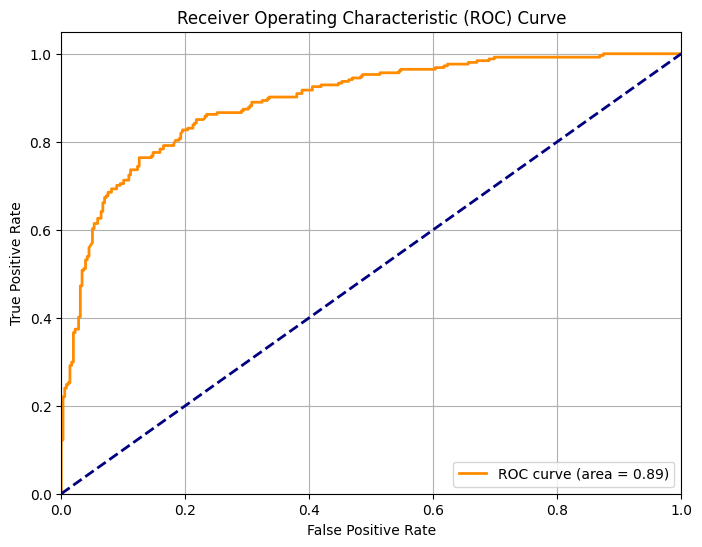

Confusion Matrix:
[[329  29]
 [ 79 175]]
Accuracy: 0.82
Precision: 0.86
Recall: 0.69
F1 Score: 0.76


In [ ]:
import deepchem as dc
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test dataset
y_true = test_dataset.y.ravel()  # Flatten y_true to a 1D array
y_pred = best_model.predict(test_dataset).reshape(-1, 2)  # Reshape y_pred to (num_samples, num_classes)

y_pred_positive = y_pred[:, 1]

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_positive)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Calculate the confusion matrix
y_pred_binary = np.argmax(y_pred, axis=1)  # Convert probabilities to binary predictions
conf_matrix = confusion_matrix(y_true, y_pred_binary)

# Calculate other evaluation metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the confusion matrix and other evaluation metrics
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [ ]:
# Make predictions on the test dataset
y_true_valid = valid_dataset.y.ravel()  # Flatten y_true to a 1D array
y_pred_valid = best_model.predict(valid_dataset).reshape(-1, 2)  # Reshape y_pred to (num_samples, num_classes)
y_pred_binary_valid = np.argmax(y_pred_valid, axis=1)  # Convert probabilities to binary predictions
valid_accuracy = accuracy_score(y_true_valid, y_pred_binary_valid)
valid_accuracy

0.7571115973741794

In [ ]:
import deepchem as dc

# Define the roc_auc_score metric
roc_auc_metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

matthew_coff= dc.metrics.Metric(dc.metrics.matthews_corrcoef)
matthew_coff=best_model.evaluate(test_dataset, [matthew_coff])
# Evaluate the model on the training dataset
kappa_score= dc.metrics.Metric(dc.metrics.kappa_score)
kappa_score=best_model.evaluate(test_dataset, [kappa_score])

train_scores = best_model.evaluate(train_dataset, [roc_auc_metric])

precision_score= dc.metrics.Metric(dc.metrics.precision_score)
# Print available keys in the train_scores dictionary
print("Available keys in train_scores:", train_scores.keys())

# Access the ROC AUC score using the correct key
roc_auc_train_score = train_scores[roc_auc_metric.name]

print('Training set ROC AUC score:', roc_auc_train_score)

# Evaluate the model on the test dataset
test_scores = best_model.evaluate(test_dataset, [roc_auc_metric])

# Print available keys in the test_scores dictionary
print("Available keys in test_scores:", test_scores.keys())

# Access the ROC AUC score using the correct key
roc_auc_test_score = test_scores[roc_auc_metric.name]

print('Test set ROC AUC score:', roc_auc_test_score)
print ('The mathew coefficient is:',matthew_coff)
print('The kappa score is:',kappa_score )
print('Precision score is:',precision_score )


Available keys in train_scores: dict_keys(['roc_auc_score'])
Training set ROC AUC score: 0.9108372359322929
Available keys in test_scores: dict_keys(['roc_auc_score'])
Test set ROC AUC score: 0.891198917872696
The mathew coefficient is: {'matthews_corrcoef': 0.6354712711196491}
The kappa score is: {'cohen_kappa_score': 0.625866050808314}
Precision score is: <deepchem.metrics.metric.Metric object at 0x7d93ad6d3670>


## Cross species evaluation

### Upload and prep for species datasets
Species datasets: eel (CHEMBL4078), cow (CHEMBL4768), mouse (CHEMBL3199), ray (CHEMBL4780), mosquito (CHEMBL2046266), mouse (CHEMBL3198), and independent  human dataset containing molecules not present on  ChEMBL22  were obtained from Vignaux et al(2023) for validation and specificity inferences.

In [ ]:
df_humanIndependent=pd.read_excel('/content/drive/MyDrive/Predictive Generative transfer learning/TransferAll/CleanedTestDatasetSmiles/df_humanIndependent.xlsx')
df_eel=pd.read_excel('/content/drive/MyDrive/Predictive Generative transfer learning/TransferAll/CleanedTestDatasetSmiles/df_eel.xlsx')
df_mouse=pd.read_excel('/content/drive/MyDrive/Predictive Generative transfer learning/TransferAll/CleanedTestDatasetSmiles/df_mouse.xlsx')
df_cow=pd.read_excel('/content/drive/MyDrive/Predictive Generative transfer learning/TransferAll/CleanedTestDatasetSmiles/df_cow.xlsx')
df_ray=pd.read_excel('/content/drive/MyDrive/Predictive Generative transfer learning/TransferAll/CleanedTestDatasetSmiles/df_ray.xlsx')
df_mosquito=pd.read_excel('/content/drive/MyDrive/Predictive Generative transfer learning/TransferAll/CleanedTestDatasetSmiles/df_mouse.xlsx')

In [ ]:
df_humanIndependent.to_csv('inhibitor_HumanIndependent.csv', index=False)
df_eel.to_csv('inhibitor_eel.csv', index=False)
df_mouse.to_csv('inhibitor_mouse.csv', index=False)
df_cow.to_csv('inhibitor_cow.csv', index=False)
df_ray.to_csv('inhibitor_ray.csv', index=False)
df_mosquito.to_csv('inhibitor_mosquito.csv', index=False)

### human

In [ ]:
# Define the ConvMolFeaturizer
featurizer = dc.feat.MolGraphConvFeaturizer()
# Featurize the SMILES column
features = featurizer.featurize(df_humanIndependent['cleanedMol'].tolist())

# Extract the target values from the DataFrame
targets = df_humanIndependent['binary_activities'].tolist()

# Create a DeepChem dataset from the features and targets
dataset_humanIndependent= dc.data.NumpyDataset(features, targets)

### eel

In [ ]:

# Define the ConvMolFeaturizer
featurizer = dc.feat.MolGraphConvFeaturizer()

# Featurize the SMILES column
features = featurizer.featurize(df_eel['cleanedMol'].tolist())

# Extract the target values from the DataFrame
targets = df_eel['single-class-label'].tolist()

# Create a DeepChem dataset from the features and targets
dataset_eel= dc.data.NumpyDataset(features, targets)

### cow

In [ ]:

# Define the ConvMolFeaturizer
featurizer = dc.feat.MolGraphConvFeaturizer()

# Featurize the SMILES column
features = featurizer.featurize(df_cow['cleanedMol'].tolist())

# Extract the target values from the DataFrame
targets = df_cow['single-class-label'].tolist()

# Create a DeepChem dataset from the features and targets
dataset_cow= dc.data.NumpyDataset(features, targets)


### mosquito

In [ ]:
# Define the ConvMolFeaturizer
featurizer = dc.feat.MolGraphConvFeaturizer()

# Featurize the SMILES column
features = featurizer.featurize(df_mosquito['cleanedMol'].tolist())

# Extract the target values from the DataFrame
targets = df_mosquito['single-class-label'].tolist()

# Create a DeepChem dataset from the features and targets
dataset_mosquito= dc.data.NumpyDataset(features, targets)

### ray

In [ ]:
# Define the ConvMolFeaturizer
featurizer = dc.feat.MolGraphConvFeaturizer()

# Featurize the SMILES column
features = featurizer.featurize(df_ray['cleanedMol'].tolist())

# Extract the target values from the DataFrame
targets = df_ray['single-class-label'].tolist()

# Create a DeepChem dataset from the features and targets
dataset_ray= dc.data.NumpyDataset(features, targets)

### mouse

In [ ]:
# Define the ConvMolFeaturizer
featurizer = dc.feat.MolGraphConvFeaturizer()
# Featurize the SMILES column
features = featurizer.featurize(df_mouse['cleanedMol'].tolist())
# Extract the target values from the DataFrame
targets = df_mouse['single-class-label'].tolist()
# Create a DeepChem dataset from the features and targets
dataset_mouse= dc.data.NumpyDataset(features, targets)

### Cross species evaluation

Confusion Matrix for Human Test dataset:
[[329  29]
 [ 79 175]]
Confusion Matrix for Human Independent dataset:
[[116  22]
 [ 22  48]]
Confusion Matrix for Eel dataset:
[[2872  503]
 [1318  766]]
Confusion Matrix for Mouse dataset:
[[167  56]
 [ 43 102]]
Confusion Matrix for Cow dataset:
[[174  44]
 [ 91 148]]
Confusion Matrix for Ray dataset:
[[515 204]
 [302 385]]
Confusion Matrix for Mosquito dataset:
[[167  56]
 [ 43 102]]


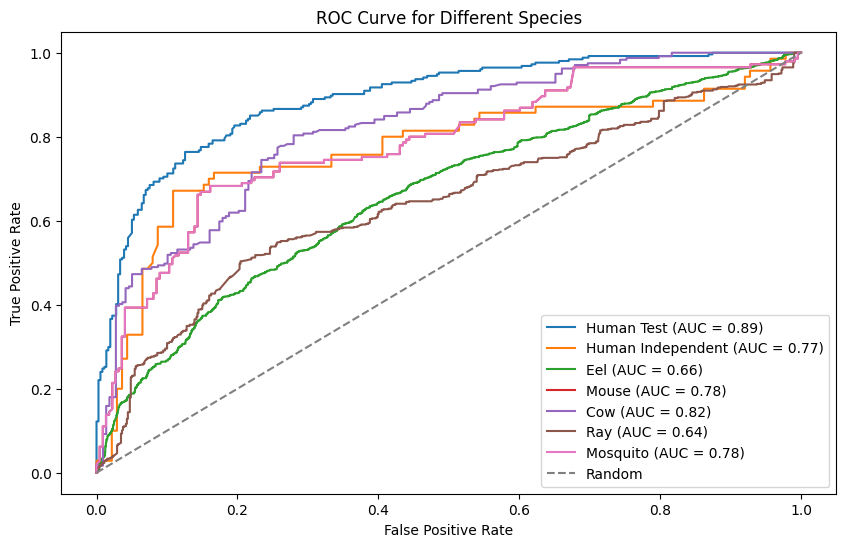

Evaluation for Human Test dataset:
Accuracy: 0.8235
Precision: 0.8578
Recall: 0.6890
F1 Score: 0.7642
MCC: 0.6355
Cohen's Kappa: 0.6259


Evaluation for Human Independent dataset:
Accuracy: 0.7885
Precision: 0.6857
Recall: 0.6857
F1 Score: 0.6857
MCC: 0.5263
Cohen's Kappa: 0.5263


Evaluation for Eel dataset:
Accuracy: 0.6664
Precision: 0.6036
Recall: 0.3676
F1 Score: 0.4569
MCC: 0.2513
Cohen's Kappa: 0.2362


Evaluation for Mouse dataset:
Accuracy: 0.7310
Precision: 0.6456
Recall: 0.7034
F1 Score: 0.6733
MCC: 0.4465
Cohen's Kappa: 0.4453


Evaluation for Cow dataset:
Accuracy: 0.7046
Precision: 0.7708
Recall: 0.6192
F1 Score: 0.6868
MCC: 0.4224
Cohen's Kappa: 0.4135


Evaluation for Ray dataset:
Accuracy: 0.6401
Precision: 0.6537
Recall: 0.5604
F1 Score: 0.6034
MCC: 0.2803
Cohen's Kappa: 0.2776


Evaluation for Mosquito dataset:
Accuracy: 0.7310
Precision: 0.6456
Recall: 0.7034
F1 Score: 0.6733
MCC: 0.4465
Cohen's Kappa: 0.4453




In [ ]:
import deepchem as dc
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score

datasets = {
    'Human Test': test_dataset,
    'Human Independent': dataset_humanIndependent,
    'Eel': dataset_eel,
    'Mouse': dataset_mouse,
    'Cow': dataset_cow,
    'Ray': dataset_ray,
    'Mosquito': dataset_mosquito
}

# Set up the plot
plt.figure(figsize=(10, 6))

# Initialize a dictionary to store evaluation metrics for each dataset
evaluation_metrics = {}

# Evaluate and plot ROC curve for each dataset
for species, data in datasets.items():
    X = data.X
    y_true = data.y.ravel()

    # Make predictions on the test dataset
    y_pred = best_model.predict(data).reshape(-1, 2)

    y_pred_positive = y_pred[:, 1]

    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_positive)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Calculate the confusion matrix
    y_pred_binary = np.argmax(y_pred, axis=1)  # Convert probabilities to binary predictions
    conf_matrix = confusion_matrix(y_true, y_pred_binary)

    # Calculate other evaluation metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    mcc = matthews_corrcoef(y_true, y_pred_binary)
    cohen_kappa = cohen_kappa_score(y_true, y_pred_binary)

    # Store the evaluation metrics in the dictionary
    evaluation_metrics[species] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'MCC': mcc,
        "Cohen's Kappa": cohen_kappa
    }

    # Plot the ROC curve for each species
    plt.plot(fpr, tpr, label=f'{species} (AUC = {roc_auc:.2f})')

    # Display Confusion Matrix
    print(f"Confusion Matrix for {species} dataset:")
    print(conf_matrix)

# Plot settings
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve for Different Species')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Display or analyze the stored evaluation metrics
for species, metrics in evaluation_metrics.items():
    print(f"Evaluation for {species} dataset:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    print("\n")

# Create a DataFrame from the evaluation_metrics dictionary
df_metrics = pd.DataFrame(evaluation_metrics).transpose()

# Save the DataFrames to Excel files
df_metrics.to_excel('evaluation_metrics_GAT.xlsx', index_label='Species')



##References
* Ramsundar, B., Eastman, P., Walters, P., Pande, V., Leswing, K., & Wu, Z. (2019). Deep Learning for the Life Sciences. O’Reilly Media. https://www.amazon.com/Deep-Learning-Life-Sciences-Microscopy/dp/1492039837
* Vignaux, P. A., Lane, T. R., Urbina, F., Gerlach, J., Puhl, A. C., Snyder, S. H., & Ekins, S. (2023). Validation of Acetylcholinesterase Inhibition Machine Learning Models for Multiple Species. Chemical Research in Toxicology, 36(2), 188–201. https://doi.org/10.1021/acs.chemrestox.2c00283
* Duvenaud, D., Maclaurin, D., Aguilera-Iparraguirre, J., Gómez-Bombarelli, R., Hirzel, T., Aspuru-Guzik, A., & Adams, R. P. (2015). Convolutional Networks on Graphs for Learning Molecular Fingerprints (arXiv:1509.09292). arXiv. http://arxiv.org/abs/1509.09292
* Gilmer, J., Schoenholz, S. S., Riley, P. F., Vinyals, O., & Dahl, G. E. (2017, July). Neural message passing for quantum chemistry. In International conference on machine learning (pp. 1263-1272). PMLR.
